# Model Comparison
By: Griffin Hosseinzadeh (2025 May 7)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

We'll start by generating some synthetic data from a slightly more complicated model than usual. The true underlying model will be a straight line plus a sinusoid. Imagine, for example, that these data are measurements of the brightness of a variable star over time. It could have short-timescale oscillations in brightness while also increasing in average brightness over the long term. Let's model this as
$$ y_3(x) = m x + b + a\sin(2\pi x) $$
where the three model parameters are the slope $m$, the intercept $b$, and the amplitude of the oscillations $a$.
We're going to compare this model with a simpler model without the oscillations:
$$ y_2(x) = m x + b $$
When we have noisy data, we may not be able to tell the difference between these two models.

First, write both these models down as function. We will want to call them later on.

In [2]:
def model3(x, m, b, a):
    y = (m * x) + b + (a * np.sin(2 * np.pi * x)) 
    return   y

def model2(x, m, b):
    y = (m * x) + b
    return   y

Generate 100 random points in the range $0<x<1$ and evaulate the true model ($y_3$) at these points given the parameters below. Then add Gaussian noise to each point using the value of $\sigma$ below. Plot your synthetic data set (with error bars) and visually compare it with your two proposed models.

Text(0.5, 1.0, 'Synthetic Data Set vs. Models')

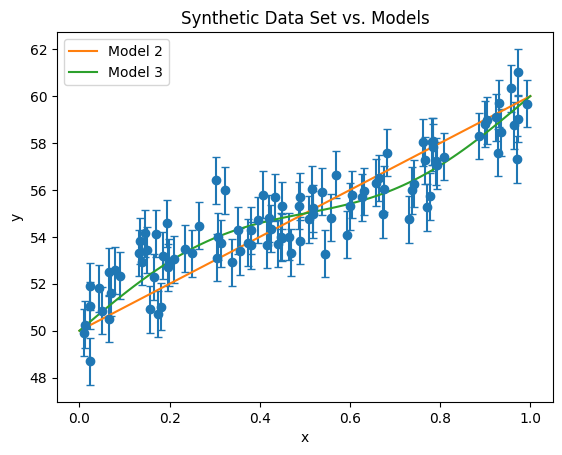

In [7]:
N = 100       # number of points
m_true = 10.  # slope
b_true = 50.  # intercept
a_true = 1.   # amplitude
sigma = 1.    # scatter

rng = np.random.default_rng(seed=13579)
x = rng.uniform(0., 1., size=N)  # random values between 0 and 1
y_noise_free = model3(x, m_true , b_true, a_true) 
y =  y_noise_free + rng.normal(0., sigma, size=N)  # Add gaussian noise to model
dy =  np.repeat(sigma, N) # array of error bars for all the data (all `sigma`)

x_range = np.linspace(0, 1, 100)
x_model =  np.array(x_range)
y_model2 =  model2(x_model, m_true , b_true) 
y_model3 =  model3(x_model, m_true , b_true, a_true) 

plt.errorbar(x, y, yerr=dy, fmt='o', capsize=3)
plt.plot(x_model, y_model2, label='Model 2')
plt.plot(x_model, y_model3, label='Model 3')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Synthetic Data Set vs. Models')


From now on, we are pretending we don't know which model is true, or what the true values of the parameters are. We have a data set, and we want to figure out which model is a a better fit, and whether it is significantly better or not, given the different numbers of parameters.

For each model, write down functions for the logarithm of the prior, likelihood, and posterior. **Make sure your prior is properly normalized.** Use these functions to calculate the Bayesian evidence for each model. This is very similar to what we did in the Bayesian statistics exercise, with one additional step: numerical integration (`np.trapezoid`) of the entire posterior grid.

In [10]:
m_min = 0.5  # technically cannot be =0 for a log-uniform prior
m_max = 99.5
b_min = 0.5
b_max = 99.5

#Log prior for model 2
def log_prior2(theta):
    
    m_mod, b_mod = theta

    #Log-uniform prior for m, normalized over [m_min, m_max]
    if m_min < m_mod < m_max:
        prob_m = 1. / (m_mod * np.log(m_max / m_min))  # Log prior normalized
    else:
        prob_m = 0.    #log(0)

    #Log-uniform prior for b, normalized over [b_min, b_max]
    if b_min < b_mod < b_max:
        prob_b = 1. / (b_max - b_min)  # Log prior normalized
    else:
        prob_b = 0.    #log(0)
    
    prob_total = prob_m * prob_b  # Combined probability
    ln_prior = np.log(prob_total)  # Log of the combined probability
    return ln_prior   # Return log-probability or -inf if zero

    
def log_likelihood2(theta, x, y, dy):
    
    m_mod, b_mod = theta

    # model 2 for y
    y_model = m_mod * x + b_mod

    chi2 = (y - y_model) ** 2. / dy ** 2.  # residuals squared / variance
    ln_like = -0.5 * np.sum(chi2)
    return ln_like


def log_posterior2(theta, x, y, dy):

    # Log-posterior = log-prior + log-likelihood (Bayes' Theorem)
    ln_post = log_prior2(theta) + log_likelihood2(theta, x, y, dy)  # From Bayes Theorem
    return ln_post


# Defining a grid over parameter space for slope and intercept
#2D arrays covering the entire parameter space
m_range2 =  np.linspace(m_min, m_max, 200)  # test 200 slope values
b_range2 = np.linspace(b_min, b_max, 200)  # test 200 intercept values 

# Create 2D meshgrid for parameter combinations
m_grid2, b_grid2 = np.meshgrid(m_range2, b_range2, indexing='ij')  # shape (200, 200)

# Initialize grid for posterior values
posterior_grid2 =  posterior_grid2 = np.zeros_like(m_grid2)

# Evaluate posterior at each grid point
for i in range(len(m_range2)):
    for j in range(len(b_range2)):
        theta = (m_range2[i], b_range2[j])  # each (m, b) pair
        posterior_grid2[i, j] = np.exp(log_posterior2(theta, x, y, dy))  # exp(log posterior)

# Numerically integrate posterior over all parameter space to get Bayesian evidence
evidence2 =  np.trapezoid(    #integrate over m
    np.trapezoid(posterior_grid2, b_range2, axis=1), m_range2, axis=0   #integrate over b first
)

print(evidence2)
#How well does this model predict the data, averaging over all possible parameter values? 
#E(M_2) = 1.114*10^-28, can evaluate model accuracy using model 3 relation
#B_3,2 = E(M_3) / E(M_2)

/var/folders/cm/jf6hy2hn17z88zc3pqtzqr_00000gn/T/ipykernel_3325/507072898.py:24: RuntimeWarning: divide by zero encountered in log
  ln_prior = np.log(prob_total)  # Log of the combined probability


1.1139894284652674e-28


In [11]:
a_min = 0.1
a_max = 10.

#Log prior for model 3
def log_prior3(theta):
     
    m_mod, b_mod, a_mod = theta

    #Log-uniform prior for m, normalized over [m_min, m_max]
    if m_min < m_mod < m_max:
        prob_m = 1. / (m_mod * np.log(m_max / m_min))   # Log prior with normalization
    else:
        prob_m = 0.

    #Log-uniform prior for b, normalized over [b_min, b_max]
    if b_min < b_mod < b_max:
        prob_b = 1. / (b_max - b_min)   # Uniform prior with normalization
    else:
        prob_b = 0.    #log(0)

    #Log-uniform prior for a, normalized over [a_min, a_max]
    if a_min < a_mod < a_max:
        prob_a = 1. / (a_max - a_min)
    else:
        prob_a = 0.

    prob_total = prob_m * prob_b * prob_a # Combined probability
    if prob_total == 0.:
        return -np.inf
    else:
        ln_prior = np.log(prob_total)  # Log of the combined probability
        return ln_prior    # Return log-probability or -inf if zero


def log_likelihood3(theta, x, y, dy):
    
    m_mod, b_mod, a_mod = theta

    # model 3 for y
    y_model = m_mod * x + b_mod + a_mod * np.sin(2 * np.pi * x)
    
    chi2 = (y - y_model) ** 2. / dy ** 2. # residuals squared / variance
    return -0.5 * np.sum(chi2)


def log_posterior3(theta, x, y, dy):
    
    # Log-posterior = log-prior + log-likelihood (Bayes' Theorem)
    ln_post = log_prior3(theta) + log_likelihood3(theta, x, y, dy)   # From Bayes Theorem
    return ln_post




m_range3 =  np.linspace(m_min, m_max, 100)  # test 100 slope values
b_range3 =  np.linspace(b_min, b_max, 100)  # test 100 intercept values
a_range3 = np.linspace(a_min, a_max, 100)  # test 100 intercept values

# posterior grid holds the posterior probability at each grid point
posterior_grid3 = np.zeros((len(m_range3), len(b_range3), len(a_range3)))

# Evaluate posterior at each grid point
for i, m_val in enumerate(m_range3):
    for j, b_val in enumerate(b_range3):
        for k, a_val in enumerate(a_range3):
            theta3 = (m_val, b_val, a_val)  # each (m, b, a) pair
            posterior_grid3[i, j, k] = np.exp(log_posterior3(theta3, x, y, dy))  # exp(log posterior)

# Numerically integrate posterior over all parameter space to get Bayesian evidence
evidence3 =  np.trapezoid(
    np.trapezoid(
        np.trapezoid(posterior_grid3, a_range3, axis=2), 
        b_range3, axis=1),
    m_range3, axis=0
)
print(evidence3)

1.3137782847121085e-27


Calculate the odds ratio for the 3-parameter model compared to the 2-parameter model. What does this number tell you? Does it agree with your intuition from the plot you made above?

In [12]:
B_32 = evidence3 / evidence2
print("Bayes factor (Model 3 vs Model 2):", B_32)

Bayes factor (Model 3 vs Model 2): 11.793453789970775


*This Bayes factor supports Model 3, this makes sense because the model 2, orange plot fits the general trend, while missing the oscillatory structure of the data, while the green fit better suits the data*

Now calculate the Akaike and Bayesian information criteria (AIC & BIC). For the sake of time, do not worry about determining the actual maximum-likelihood parameter values. Just use the true parameter values we used to synthesize the data at the beginning of this notebook. (Presumably those should be close to the maximum-likelihood values.) What do the AIC and BIC tell you? Do they agree with the odds ratio and/or your intuition?

In [15]:
N = 100       # number of points
k2 = 2        # number of params
k3 = 3

#taking the log likeli of our true parameters 
theta2_true = (m_true, b_true)
theta3_true = (m_true, b_true, a_true)
Log_Lik2 = log_likelihood2(theta2_true, x, y, dy)
Log_Lik3 = log_likelihood3(theta3_true, x, y, dy)

# Akaike
aic2 =  -2 * Log_Lik2 + 2 * k2
aic3 =  -2 * Log_Lik3 + 2 * k3
print("AIC model 2:", aic2, "AIC model 3:", aic3, "Change in AIC:", aic2 - aic3)

# Bayesian
bic2 =  -2 * Log_Lik2 + 2 * k2 * np.log(N)
bic3 =  -2 * Log_Lik3 + 2 * k3 * np.log(N)
print("BIC model 2:", bic2, "BIC model 3:", bic3, "Change in BIC:", bic2 - bic3)

AIC model 2: 154.6541887882873 AIC model 3: 106.49753650860667 Change in AIC: 48.15665227968064
BIC model 2: 169.0748695322397 BIC model 3: 128.12855762453523 Change in BIC: 40.946311907704455


*The high change in AIC and change in BIC values support the odds ratio, the added parameter of model 3 provides a better fit for the data*

Now repeat this entire notebook using a different data set with increased noise. Either duplicate this entire notebook (File > Duplicate), in which case you need to add that new notebook to the GitHub repository, or copy all the code cells above and paste them below. *(Yes, you could just change the number and rerun the notebook, but we want to see a record of both.)*

This time, increase $\sigma$ to 5. Comment on your results, specifically whether or not you can distinguish between the two models, and whether you think that is reasonable or not.

*Complete*